<a href="https://colab.research.google.com/github/lee4205/Potato_Chip_Classification/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://@github.com/lee4205/Potato_Chip_Classification.git
!git config --global user.email "leejinyien4205@gmail.com"
!git config --global user.name "lee4205"

Cloning into 'Potato_Chip_Classification'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 2031 (delta 85), reused 81 (delta 23), pack-reused 1823
Receiving objects: 100% (2031/2031), 156.60 MiB | 34.15 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [2]:
cd Potato_Chip_Classification

/content/Potato_Chip_Classification


In [3]:
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [4]:
image_width = 1280 // 10
image_height = 960 // 10
image_size = (image_width, image_height)
image_channel = 1

In [5]:
cwd = os.getcwd()
flavors = os.listdir(cwd + "/potato-chips")

In [6]:
pixels = []
pixel = 0
for x in range(image_width * image_height):
    pixel += 1
    pixels.append('pixel' + str(pixel))

In [7]:
with open("potato_chips.csv", 'a') as c:
    csv_input = csv.writer(c)
    header = ["image", "flavor"]
    header.extend(pixels)
    csv_input.writerow(header)

    for flavor in flavors:
        print("loading image from " + flavor + " ...")
        images = os.listdir(cwd + f"/potato-chips/{flavor}")
        for image in images:
            rgb_image = Image.open(cwd + f"/potato-chips/{flavor}/" + image)
            grey_image = rgb_image.convert('L').resize((image_width, image_height))
            pixel_data = np.asarray(grey_image.getdata(), dtype=np.int).reshape((grey_image.size[1], grey_image.size[0]))
            pixel_data = pixel_data.flatten()
            image_data = [image, flavors.index(flavor)]
            image_data.extend(pixel_data)
            csv_input.writerow(image_data)

loading image from consomme-punch ...
loading image from norishio-punch ...
loading image from norishio ...
loading image from shiawase-butter ...
loading image from kyusyu-shoyu ...
loading image from usushio ...
loading image from shoyu-mayo ...


In [8]:
df = pd.read_csv(cwd + "/potato_chips.csv")

In [9]:
train_df, validate_df = train_test_split(df, train_size=0.6, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
# デバッグ用
# train_df
# validate_df
# test_df
# plt.figure(figsize=(15, 15))
# sns.set_style("darkgrid")
# sns.countplot(train_df['flavor'])
# sns.countplot(validate_df['flavor'])
# sns.countplot(test_df['flavor'])

In [11]:
y_train = train_df['flavor']
y_validate = validate_df['flavor']
y_test = test_df['flavor']
y = test_df['flavor']

In [12]:
del train_df['image'], train_df['flavor']
del validate_df['image'], validate_df['flavor']
del test_df['image'], test_df['flavor']

In [13]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_validate = label_binarizer.fit_transform(y_validate)
y_test = label_binarizer.fit_transform(y_test)

In [14]:
x_train = train_df.values
x_validate = validate_df.values
x_test = test_df.values

In [15]:
x_train = x_train / 255
x_validate = x_validate / 255
x_test = x_test / 255

In [16]:
x_train = x_train.reshape(-1, image_height, image_width, 1)
x_validate = x_validate.reshape(-1, image_height, image_width, 1)
x_test = x_test.reshape(-1, image_height, image_width, 1)

In [17]:
# デバッグ用
# f, ax = plt.subplots(3, 3)
# f.set_size_inches(10, 10)
# k = 0
# for i in range(3):
#     for j in range(3):
#         ax[i, j].imshow(x_train[k].reshape(image_height, image_width), cmap="gray")
#         k += 1
#     plt.tight_layout() 

In [18]:
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False)
datagen.fit(x_train)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(image_width, image_height, image_channel)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 96, 75)       750       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 96, 75)       300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 48, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 48, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 64, 48, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 48, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 24, 50)        0

In [21]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=5),
                    epochs=500,
                    validation_data=(x_validate, y_validate),
                    callbacks=[learning_rate_reduction])

Epoch 1/500
86/86 [==============================] - 28s 311ms/step - loss: 4.5300 - accuracy: 0.2769 - val_loss: 4.9042 - val_accuracy: 0.1958
Epoch 2/500
86/86 [==============================] - 26s 308ms/step - loss: 2.4117 - accuracy: 0.4018 - val_loss: 8.2780 - val_accuracy: 0.1958
Epoch 3/500
86/86 [==============================] - 26s 307ms/step - loss: 1.5488 - accuracy: 0.5288 - val_loss: 6.8122 - val_accuracy: 0.1958

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/500
86/86 [==============================] - 26s 307ms/step - loss: 1.1325 - accuracy: 0.6091 - val_loss: 5.7422 - val_accuracy: 0.1958
Epoch 5/500
86/86 [==============================] - 26s 306ms/step - loss: 0.9371 - accuracy: 0.6540 - val_loss: 3.6461 - val_accuracy: 0.3007
Epoch 6/500
86/86 [==============================] - 27s 309ms/step - loss: 0.9297 - accuracy: 0.6694 - val_loss: 1.9623 - val_accuracy: 0.4476
Epoch 7/500
86/86 [==============================] - 27

In [22]:
print("Accuracy of the model : ", model.evaluate(x_validate, y_validate)[1] * 100, "%")

5/5 [==============================] - 2s 301ms/step - loss: 0.2304 - accuracy: 0.9371
Accuracy of the model :  93.7062919139862 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


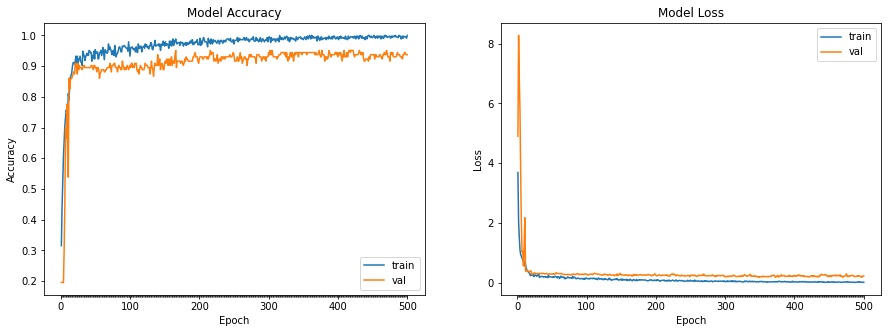

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(range(1, len(history.history["accuracy"]) + 1), history.history["accuracy"])
axs[0].plot(range(1, len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"])
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_xticks(np.arange(1, len(history.history["accuracy"]) + 1), len(history.history["accuracy"]) / 10)
axs[0].legend(["train", "val"], loc="best")
axs[1].plot(range(1, len(history.history["loss"]) + 1), history.history["loss"])
axs[1].plot(range(1, len(history.history["val_loss"]) + 1), history.history["val_loss"])
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xticks(np.arange(1, len(history.history["loss"]) + 1), len(history.history["loss"]) / 10)
axs[1].legend(["train", "val"], loc="best")
plt.show()

In [24]:
predictions = model.predict_classes(x_test)
print(predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[6 4 2 3 2 0 2 2 2 4 1 3 5 5 4 4 6 2 0 0 3 0 1 6 0 1 6 0 4 5 6 6 3 3 3 2 6
 4 4 2 4 3 6 1 2 5 4 5 3 3 0 4 6 3 2 1 6 0 1 1 0 0 5 3 3 1 3 3 5 1 3 4 2 0
 0 2 3 1 0 0 4 4 6 2 1 3 6 3 3 5 3 3 1 1 5 2 3 1 2 0 1 3 5 3 1 3 1 4 6 0 4
 1 6 2 0 4 1 2 6 2 0 2 2 5 4 5 0 2 3 0 3 3 0 5 3 2 0 2 6 4 5 3 0]


In [25]:
classes = ["Class " + str(i) for i in range(8) if i != 0]
print(classification_report(y, predictions, target_names=classes))

              precision    recall  f1-score   support

     Class 1       1.00      0.85      0.92        27
     Class 2       0.95      1.00      0.97        18
     Class 3       0.83      1.00      0.90        19
     Class 4       1.00      1.00      1.00        30
     Class 5       1.00      1.00      1.00        18
     Class 6       1.00      0.93      0.97        15
     Class 7       1.00      1.00      1.00        16

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



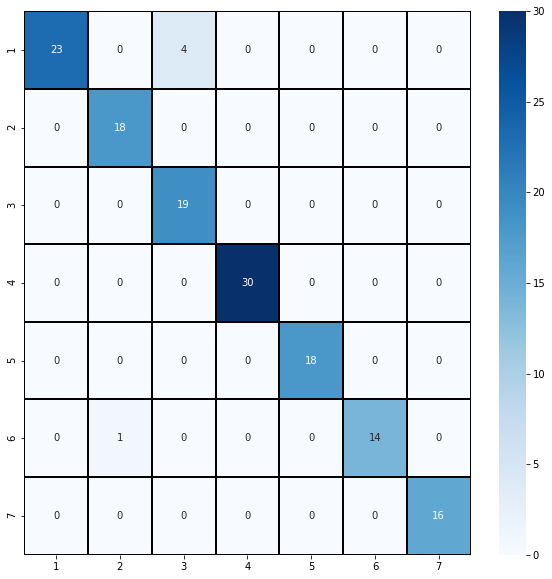

In [26]:
cm = confusion_matrix(y, predictions)
cm = pd.DataFrame(cm, index=[i for i in range(8) if i != 0], columns=[i for i in range(8) if i != 0])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='')

In [27]:
correct = (predictions == y).to_numpy().nonzero()[0]

In [1]:
i = 0
plt.figure(figsize=(10, 10))
for c in correct[:9]:
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[c].reshape(image_height, image_width), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\n Actual Class {}".format(flavors[predictions[c]], flavors[y[c]]))
    i += 1

NameError: ignored